# Init

In [16]:
import torch
import sympy  as sp
import plotly.graph_objects as go

# Nevergrad Imports
import nevergrad as ng

# Symxplorer Specific Imports
from   symxplorer.symbolic_solver.domains        import ExperimentResult

from   symxplorer.designer_tools.tf_models       import First_Order_LP_TF, Second_Order_LP_TF, cascade_tf
from   symxplorer.designer_tools.visualizer      import Symbolic_Visualizer, Bode_Visualizer
# Optimizer wrapper
from   symxplorer.designer_tools.evolutionary_nevergrad import Nevergrad_Symbolic_Bode_Fitter

s = sp.symbols("s")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype  = torch.double

torch.set_default_dtype(dtype)
torch.set_default_device(device)
print(f'Using device: {device} and dtype: {dtype}')

Using device: cpu and dtype: torch.float64


In [17]:
path_to_pkl = "Runs/results.pkl"
symbolic_experiment_result = ExperimentResult("Sizing Stage")
symbolic_experiment_result = symbolic_experiment_result.load(path_to_pkl)

# Problem Setup

In [18]:
selected_filters = symbolic_experiment_result.get_filter_types("X-INVALID-ORDER")
len(selected_filters)

3190

In [19]:
idx = 2365 # 2365 is the ID of our case study

z_key = selected_filters[idx].zCombo
tf_to_size = selected_filters[idx].transferFunc
tf_to_size

R_1*R_2*R_6/(C_1*C_4*C_6*R_1*R_2*R_3*R_5*R_6*s**3 + R_1*R_5 - R_2*R_3 + R_2*R_5 + R_3*R_5 + s**2*(C_1*C_4*R_1*R_2*R_3*R_5 - C_1*C_6*R_1*R_2*R_3*R_6 + C_1*C_6*R_1*R_2*R_5*R_6 + C_1*C_6*R_1*R_3*R_5*R_6 + C_4*C_6*R_2*R_3*R_5*R_6) + s*(-C_1*R_1*R_2*R_3 + C_1*R_1*R_2*R_5 + C_1*R_1*R_3*R_5 + C_4*R_2*R_3*R_5 + C_6*R_1*R_5*R_6 - C_6*R_2*R_3*R_6 + C_6*R_2*R_5*R_6 + C_6*R_3*R_5*R_6))

In [20]:
frequencies = torch.logspace(5, 10, 20000)

# Butterworth Filter (3rd order)
fc = 1e7
tf1 = Second_Order_LP_TF(q=1, fc=1.272*fc, dc_gain=1e3)
tf2 = First_Order_LP_TF(fc=1*fc, dc_gain=1)

target_tf = cascade_tf(list_of_tfs=[tf1, tf2], dc_gain_multiplier=1)
target_tf

1000.0/((5.0e-8*s/pi + 1)*(1.54513270835806e-15*s**2/pi**2 + 3.93081761006289e-8*s/pi + 1))

Calculating Phases: 100%|██████████| 200/200 [00:01<00:00, 149.06it/s]


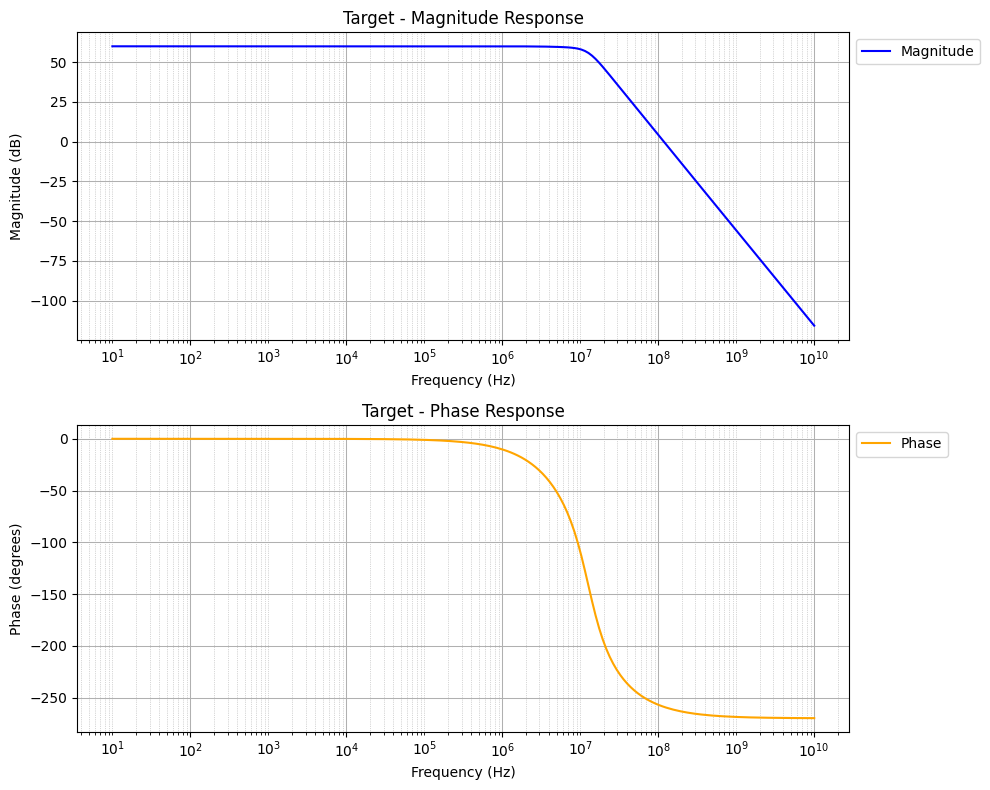

In [21]:
from symxplorer.designer_tools.visualizer import Symbolic_Visualizer

vis = Symbolic_Visualizer(tf=target_tf)
vis.visualize(start_freq_order=1, end_freq_order=10, num_of_points=200, title="Target")

In [22]:
# Define range
lower_bound = 1e6
upper_bound = 12e6

# Generate binary mask
weighted_frequencies = torch.where((frequencies >= lower_bound) & (frequencies <= upper_bound), 1, 1)

# Optimizer

In [36]:
print({x for x in ng.optimizers.registry})

{'HullCenterHullAvgCauchyScrHammersleySearch', 'ManyLN', 'HullCenterHullAvgScrHammersleySearchPlusMiddlePoint', 'NGOpt', 'NoisyRL2', 'CMAILL', 'SmoothLognormalDiscreteOnePlusOne', 'ChainDEwithLHS30', 'NgIoh13', 'PolyCMA', 'SADiscreteLenglerOnePlusOneExp09Auto', 'HullCenterHullAvgLargeHammersleySearch', 'NGOptRW', 'DiscreteNoisy13Splits', 'NgIohTuned', 'MultiCobyla', 'HaltonSearch', 'LHSSearch', 'NLOPT_LN_NELDERMEAD', 'DiscreteLengler2OnePlusOne', 'NgIoh8', 'DiscreteOnePlusOneT', 'UltraSmoothDiscreteLenglerOnePlusOne', 'NGOptF', 'RFMetaModel', 'SQOPSODCMA20bar', 'NeuralMetaModelTwoPointsDE', 'ChainDEwithMetaTuneRecentering30', 'ChainDEwithLHSsqrt', 'RescaledCMA', 'ImageMetaModel', 'SmoothPortfolioDiscreteOnePlusOne', 'DS14', 'NgIoh14', 'ChainPSOwithRdim', 'SPSA', 'ScrHaltonSearch', 'NGOptSingle16', 'SplitTwoPointsDE', 'SmoothDiscreteLenglerOnePlusOne', 'LogMultiBFGSPlus', 'Powell', 'SMAC3', 'ChainPSOwithLHSdim', 'TinyCMA', 'AvgMetaRecenteringNoHull', 'OpoTinyDE', 'SADiscreteLenglerOnePl

"LogBFGSCMAPlus" optimizer has given the best result so far.

In [47]:
ng.optimizers.registry.get("LogBFGSCMAPlus")

nevergrad.optimization.optimizerlib.LogBFGSCMAPlus

In [48]:
ng_wrapper = Nevergrad_Symbolic_Bode_Fitter(
    tf_to_size=tf_to_size,
    target_tf=target_tf,
    c_range=[1e-12, 1e-9],
    r_range=[1e2, 1e5],
    frequencies=frequencies,
    # freq_weights=weighted_frequencies,
    max_loss=float('inf'),
    loss_norm_method='min-max',
    loss_type="mse",
    optimizer_name="LogBFGSCMAPlus",
    random_seed=42
)

Computing filter parameters for BiQuad:   0%|          | 0/1 [00:00<?, ?filter/s]


In [49]:
ng_wrapper.parameterize(log_scale=False)

({'C_1': Scalar{Cl(1,1000.0000000000001,b)}[sigma=Scalar{exp=2.03}]:500.50000000000006,
  'R_5': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'R_2': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'R_3': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'R_1': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'C_4': Scalar{Cl(1,1000.0000000000001,b)}[sigma=Scalar{exp=2.03}]:500.50000000000006,
  'R_6': Scalar{Cl(1,1000,b)}[sigma=Scalar{exp=2.03}]:500.5,
  'C_6': Scalar{Cl(1,1000.0000000000001,b)}[sigma=Scalar{exp=2.03}]:500.50000000000006},
 1e-12,
 100.0)

In [50]:
ng_wrapper.create_experiment(budget=5000)
ng_wrapper.optimize(include_mag_loss=False, include_phase_loss=True, render_optimization_trace=True)

Optimizer is set to LogBFGSCMAPlus with budget = 5000


Optimizing:  73%|███████▎  | 3658/5000 [02:29<00:57, 23.36trial/s]/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/cma/transformations.py:798: RuntimeWarning:

overflow encountered in exp

Optimizing: 100%|██████████| 5000/5000 [03:26<00:00, 24.18trial/s]


True

In [51]:
best_params, loss = ng_wrapper.get_best()
best_params, loss

Optimized x - normalized: {'C_1': 5.0851277772485055, 'R_5': 60.271640652446976, 'R_2': 20.5264637549578, 'R_3': 5.940490703581795, 'R_1': 321.64219541514757, 'C_4': 27.152591702343308, 'R_6': 58.580603096601436, 'C_6': 2.7183594035896026}
Optimized x - de-normalized: {'C_1': 5.085127777248505e-12, 'R_5': 6027.164065244698, 'R_2': 2052.64637549578, 'R_3': 594.0490703581795, 'R_1': 32164.219541514758, 'C_4': 2.7152591702343307e-11, 'R_6': 5858.0603096601435, 'C_6': 2.7183594035896026e-12}
loss: 7.287827727297268e-07


({'C_1': 5.085127777248505e-12,
  'R_5': 6027.164065244698,
  'R_2': 2052.64637549578,
  'R_3': 594.0490703581795,
  'R_1': 32164.219541514758,
  'C_4': 2.7152591702343307e-11,
  'R_6': 5858.0603096601435,
  'C_6': 2.7183594035896026e-12},
 7.287827727297268e-07)

In [52]:
ng_wrapper.plot_solution(best_params)

mag_loss 2.631207096458956e-08, phase_loss 7.287827727297268e-07, max-mag 65.36270904541016


## Plot

In [53]:
# best_params, loss = ng_wrapper.optimizer_trace[4200]
# best_params = ng_wrapper.denormalize_params(best_params.value)
# best_params, loss

In [54]:
ng_wrapper.plot_solution(best_params)

mag_loss 2.631207096458956e-08, phase_loss 7.287827727297268e-07, max-mag 65.36270904541016


In [55]:
# get_bode_fitness_loss()